## ArcticHeat Alamo Deployments:
** 2018 **

Template for analysis of any desired instrument

__pyversion__==3.7   
__author__==S.Bell

In [1]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2020-10-12 10:38:53.013318


### connecting and basic information

In [2]:
import warnings
#remove the numpy/pandas/cython warnings
warnings.filterwarnings(action='ignore', message="numpy.dtype size changed,")

from erddapy import ERDDAP
import pandas as pd
import numpy as np

#server_url='http://downdraft.pmel.noaa.gov:8080/erddap'
server_url='http://ferret.pmel.noaa.gov/alamo/erddap'
e = ERDDAP(server=server_url)

Get only ALAMO Float datafiles - can be found by searching for arctic.

Searching on ALAMO provides an "alldata" response that would need to be filtered out

In [3]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='arctic'))

In [4]:
alamos = df['Dataset ID'].values
print(alamos)
alamos = ['arctic_heat_alamo_profiles_9085']

['arctic_heat_alamo_profiles_11010' 'arctic_heat_alamo_profiles_11012'
 'arctic_heat_alamo_profiles_11014' 'arctic_heat_alamo_profiles_11015'
 'arctic_heat_alamo_profiles_11016' 'arctic_heat_alamo_profiles_11018'
 'arctic_heat_alamo_profiles_9058' 'arctic_heat_alamo_profiles_9076'
 'arctic_heat_alamo_profiles_9085' 'arctic_heat_alamo_profiles_9115'
 'arctic_heat_alamo_profiles_9116' 'arctic_heat_alamo_profiles_9117'
 'arctic_heat_alamo_profiles_9119' 'arctic_heat_alamo_profiles_9121'
 'arctic_heat_alamo_profiles_9150' 'arctic_heat_alamo_profiles_9152'
 'arctic_heat_alamo_profiles_9153' 'arctic_heat_alamo_profiles_9154'
 'arctic_heat_alamo_profiles_9155' 'arctic_heat_alamo_profiles_9158'
 'arctic_heat_alamo_profiles_9164' 'arctic_heat_alamo_profiles_9165'
 'arctic_heat_alamo_profiles_9167' 'arctic_heat_alamo_profiles_9168'
 'arctic_heat_alamo_profiles_9169' 'arctic_heat_alamo_profiles_9170'
 'arctic_heat_alamo_profiles_9172' 'arctic_heat_alamo_profiles_9174'
 'arctic_heat_alamo_profiles

In [5]:
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': -180.0,
    'max_lon': -130.0,
    'min_lat': 65.0,
    'max_lat': 90.0,
    'min_time': '2016-08-15T00:00:00Z',
    'max_time': '2018-12-16T00:00:00Z',
    'cdm_data_type': 'trajectoryprofile'
}

In [6]:
variables = [e.get_var_by_attr(dataset_id=alamo, standard_name=lambda v: v is not None) for alamo in alamos]

In [7]:
common_variables = set(variables[0]).intersection(*variables[1:])

common_variables.update(['CYCLE_NUMBER']) 


In [8]:
constraints = {
    'longitude>=': kw['min_lon'],
    'longitude<=': kw['max_lon'],
    'latitude>=': kw['min_lat'],
    'latitude<=': kw['max_lat'],
    'time>=': kw['min_time'],
    'time<=': kw['max_time'],
}

download_url = e.get_download_url(
    dataset_id=alamos[0],
    protocol='tabledap',
    response='csv',
    variables=common_variables,
)

print(download_url)

http://ferret.pmel.noaa.gov/alamo/erddap/tabledap/arctic_heat_alamo_profiles_9085.csv?time,PSAL,TEMP,latitude,JULD_LOCATION,PRES,longitude,CYCLE_NUMBER


### retrieving erddap and plotting data

In [9]:
from requests.exceptions import HTTPError

dfs = {}
for alamo in alamos:
    print(alamo)
    try:
        e = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        e.constraints=constraints
        e.variables=common_variables
        e.dataset_id=alamo
    except HTTPError:
        print('Failed to generate url {}'.format(alamo))
        continue
    try:
        dfs.update({alamo: e.to_pandas(
                            index_col='time (UTC)',
                            parse_dates=True
                            )})
    except:
        print('Failed to ingest {}'.format(alamo))


arctic_heat_alamo_profiles_9085


In [10]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter



In [11]:
from matplotlib import colors as mcolors


colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
clist = list(colors.keys())


In [12]:
### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

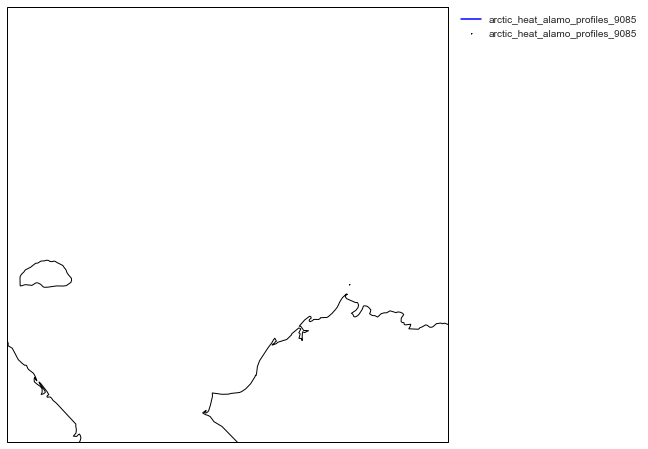

In [13]:

def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 8),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')
dx = dy = 0.5
extent = [-180, -150, 67.5, 77.5]

fig,ax = make_map(projection=projection)
acount = 0
for alamo, df in dfs.items():
    #if alamo in ['arctic_heat_alamo_profiles_9152','arctic_heat_alamo_profiles_9119']:
    ax.plot(df['longitude (degrees_east)'], df['latitude (degrees_north)'], color=colors[clist[acount]], label=alamo, transform=transformation)
    ax.plot(df['longitude (degrees_east)'], df['latitude (degrees_north)'], '+k', markersize=1, label=alamo, transform=transformation)
    acount +=4
leg = ax.legend(bbox_to_anchor=(1.45,1), loc='upper right')

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

#fig.savefig('map.svg',dpi=300)

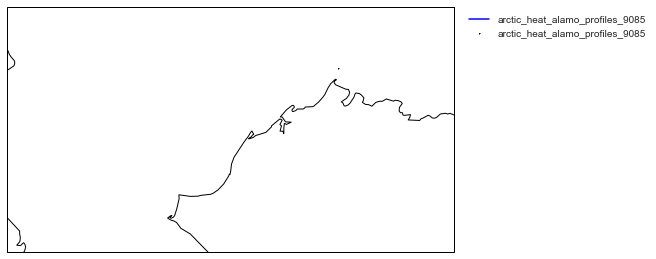

In [14]:
#zoom to chukchi
dx = dy = 0.5
extent = [-176, -150, 67.5, 72.5]

fig,ax = make_map(projection=projection)
acount = 0
for alamo, df in dfs.items():
    #if alamo in ['arctic_heat_alamo_profiles_9152','arctic_heat_alamo_profiles_9119']:
    ax.plot(df['longitude (degrees_east)'], df['latitude (degrees_north)'], color=colors[clist[acount]], label=alamo, transform=transformation)
    ax.plot(df['longitude (degrees_east)'], df['latitude (degrees_north)'], '+k', markersize=1, label=alamo, transform=transformation)
    acount +=4
leg = ax.legend(bbox_to_anchor=(1.45,1), loc='upper right')

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

#fig.savefig('map.svg',dpi=300)

or as a dynamic page seved in an iframe (needs to be a public page?)

In [15]:
def show_iframe(src):
    """Helper function to show HTML returns."""
    from IPython.display import HTML
    iframe = '<iframe src="{src}" width="100%" height="950"></iframe>'.format
    return HTML(iframe(src=src))

#show_iframe('https://www.pmel.noaa.gov')


In [16]:
df.columns

Index(['PSAL (PSU)', 'TEMP (degree_Celsius)', 'latitude (degrees_north)',
       'JULD_LOCATION (UTC)', 'PRES (decibar)', 'longitude (degrees_east)',
       'CYCLE_NUMBER'],
      dtype='object')

## Depth v Time/Dive Profiles

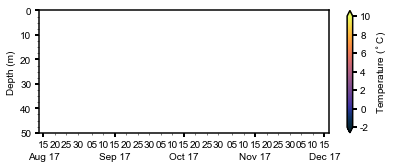

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.ticker import NullFormatter  # useful for `logit` scale
import cmocean

for dfn, df in dfs.items():
    fig, ax1 = plt.subplots(figsize=(6.5, 2.25))
    cs = ax1.scatter(df.index, df['PRES (decibar)'], s=15, c=df['TEMP (degree_Celsius)'],
                    marker='o', edgecolor='none', vmin=-2, vmax=10, cmap=cmocean.cm.thermal)

    cbar = fig.colorbar(cs, ticks=[-2, 0, 2, 4, 6, 8, 10], orientation='vertical', extend='both')
    cbar.ax.set_ylabel('Temperature ($^\circ$C)')
    cbar.ax.set_yticklabels([-2, 0, 2, 4, 6, 8, 10])
    ax1.set_ylabel('Depth (m)')
    #ax1.set_xlabel(dfn)
    
    ax1.invert_yaxis()
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
    ax1.xaxis.set_major_locator(DayLocator(bymonthday=15))
    ax1.xaxis.set_minor_locator(DayLocator(bymonthday=range(0,31,5)))
    ax1.xaxis.set_major_formatter(ticker.NullFormatter())
    ax1.xaxis.set_minor_formatter(DateFormatter('%d'))
    ax1.xaxis.set_major_formatter(DateFormatter('%b %y'))
    ax1.xaxis.set_tick_params(which='major', pad=15)
    ax1.xaxis.set_tick_params(which='minor', pad=5)
    ax1.set_xlim([datetime.datetime(2017,8,13),datetime.datetime(2017,12,17)])
    ax1.set_ylim([50,0])
    
    fig.savefig(dfn+'.kwood.png',dpi=300)
    fig.savefig(dfn+'.kwood.svg',dpi=300)    

In [ ]:
for dfn, df in dfs.items():
    fig, ax = plt.subplots(figsize=(17, 2))
    cs = ax.scatter(df.index, df['PRES (decibar)'], s=15, c=df['PSAL (PSU)'], marker='o', edgecolor='none', vmin=28, vmax=33,cmap=cmocean.cm.haline)

    ax.invert_yaxis()
    ax.set_xlim(df.index[0], df.index[-1])
    xfmt = mdates.DateFormatter('%d-%b')
    ax.xaxis.set_major_formatter(xfmt)

    cbar = fig.colorbar(cs, orientation='vertical', extend='both')
    cbar.ax.set_ylabel('Salinity (PSU)')
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel(dfn)

In [ ]:
#depth averaged temp - interpolate to 1m bins before averaging
acount=0
legend_label=[]

fig, ax = plt.subplots(figsize=(17, 2))
for dfn, df in dfs.items():
    fg = df.groupby('CYCLE_NUMBER')

    for ind,fgi in enumerate(fg.groups):
        IntTemp = np.interp(np.arange(0,50,1),fg.get_group(fgi)['PRES (decibar)'], fg.get_group(fgi)['TEMP (degree_Celsius)'], left=np.nan, right=np.nan)
        cs = ax.scatter(fg.get_group(fgi).index[0], np.nanmean(IntTemp), s=15, c=clist[acount], marker='o', edgecolor='none')

    xfmt = mdates.DateFormatter('%d-%b')
    ax.xaxis.set_major_formatter(xfmt)

    ax.set_ylabel('Temperature (degC)')
    ax.set_xlabel('Time (UTC)')
    acount+=4
    
    legend_label.append(dfn)


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(legend_label, loc='center left', bbox_to_anchor=(1, 0.5))

leg = ax.get_legend()
acount = 0
for i in range(0,len(legend_label),1):
    leg.legendHandles[i].set_color(colors[clist[acount]])
    acount+=4

In [ ]:
### Plot settings
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['font.size'] = 21
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.weight'] = 'light'
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams.update({'figure.autolayout': True})


In [ ]:
#depth averaged temp for specific bins from 1m binned/interpolated data
acount=0
legend_label=[]

fig, ax = plt.subplots(figsize=(18, 4), facecolor='w', edgecolor='w')
for dfn, df in dfs.items():
    fg = df.groupby('CYCLE_NUMBER')

    for ind,fgi in enumerate(fg.groups):
        IntTemp = np.interp(np.arange(5,15,1),fg.get_group(fgi)['PRES (decibar)'], fg.get_group(fgi)['TEMP (degree_Celsius)'], left=np.nan, right=np.nan)
        cs = ax.scatter(fg.get_group(fgi).index[0], np.nanmean(IntTemp), s=15, marker='o', edgecolor='none', facecolor='black')
        print(fg.get_group(fgi)['time (UTC)'].min(), np.nanmean(IntTemp))
        IntTemp = np.interp(np.arange(25,35,1),fg.get_group(fgi)['PRES (decibar)'], fg.get_group(fgi)['TEMP (degree_Celsius)'], left=np.nan, right=np.nan)
        cs = ax.scatter(fg.get_group(fgi).index[0], np.nanmean(IntTemp), s=15, marker='+', edgecolor='none', facecolor='blue')

    xfmt = mdates.DateFormatter('%d-%b')
    ax.xaxis.set_major_formatter(xfmt)

    ax.set_ylabel('Temperature (degC)')
    ax.set_xlabel('Time (UTC)')
    acount+=4
    
legend_label=['5-15m','25-35m']

ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(bymonthday=range(0,31,15)))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %y'))
ax.xaxis.set_tick_params(which='major', pad=20)
ax.xaxis.set_tick_params(which='minor', pad=5)
    
# Put a legend to the right of the current axis
ax.legend(legend_label)

#fig.tight_layout()
fig.savefig(alamo+'_depthave.png',dpi=300)
fig.savefig(alamo+'_depthave.svg',dpi=300)

This is not biased due to sample frequency, but it will only give the value in the region of the column measured (so incomplete profiles are not interpolated to the top and bottom)

# Sal/Temp Contour Overlay

Get data in xarray format

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

In [ ]:
### Plot settings
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['font.size'] = 10
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.weight'] = 'light'
mpl.rcParams['svg.fonttype'] = 'none'

In [ ]:
for alamo in alamos:
    print(alamo)
    try:
        e = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        e.constraints=constraints
        e.variables=common_variables
        e.dataset_id=alamo
    except HTTPError:
        print('Failed to generate url {}'.format(alamo))
        continue
    try:
        dataxa = e.to_xarray(decode_times=True)
    except:
        print('Failed to ingest {}'.format(alamo))


In [ ]:
def plot_temperature_saloverlay():
    dgb = dataxa.groupby('CYCLE_NUMBER')

    depth_array = np.arange(0,400,1)
    temparray = np.ones((len(dgb.groups.keys()),len(depth_array)))*np.nan
    temparrays = np.ones((len(dgb.groups.keys()),len(depth_array)))*np.nan
    ProfileTime = []
    cycle_col = 0

    fig, ax1 = plt.subplots(figsize=(18, 4), facecolor='w', edgecolor='w')

    for k,cycle in enumerate(dgb.groups):
        if not ((dataxa.TEMP[dataxa.CYCLE_NUMBER==cycle].shape[0])==0):
            temp_time =  dataxa.time[dataxa.CYCLE_NUMBER==cycle]
            ProfileTime = ProfileTime + [temp_time]
            #remove where pressure may be unknown
            Pressure = dataxa.PRES[dataxa.CYCLE_NUMBER==cycle]
            Temperature = dataxa.TEMP[dataxa.CYCLE_NUMBER==cycle]
            Salinity = dataxa.PSAL[dataxa.CYCLE_NUMBER==cycle]

            temparray[cycle_col,:]  = np.interp(depth_array,Pressure.data,Temperature.data,left=np.nan,right=np.nan)
            temparrays[cycle_col,:] = np.interp(depth_array,Pressure.data,Salinity.data,left=np.nan,right=np.nan)

            cycle_col +=1

            ###plot black dots at sample points
            #plt.scatter(x=temp_time.data, y=Pressure,s=1,marker='.', edgecolors='none', c='k', zorder=3, alpha=1)
            ###plot colored dots at sample points with colorscheme based on  variable value
            plt.scatter(x=temp_time.data, y=Pressure,s=30,marker='.', edgecolors='none', c=Temperature, 
              vmin=-2, vmax=10, cmap=cmocean.cm.thermal, zorder=2)
        else:
            print("empty")

    time_array = np.array([x[0].data for x in ProfileTime])
    cs = plt.contourf(time_array,depth_array,temparray.T, 
        extend='both', cmap=cmocean.cm.thermal, 
        levels=np.arange(-2,10.25,0.25), alpha=0.9,zorder=1)
    cbar = fig.colorbar(cs, ticks=range(-2,12,2), orientation='vertical', extend='both')
    cbar.ax.set_ylabel('Temperature ($^\circ$C)')

    plt.contour(time_array,depth_array,temparray.T,np.arange(-2,10,1), colors='#d3d3d3',linewidths=1, alpha=0.5,zorder=3)

    CS=plt.contour(time_array,depth_array,temparrays.T,np.arange(30,33,0.5),linewidths=1.0, linestyles='dashed',colors='#000000',zorder=4)
    plt.clabel(CS, inline=1, fontsize=16, fmt='%1.2f')

    ax1.invert_yaxis()
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
    ax1.xaxis.set_major_locator(DayLocator(bymonthday=15))
    ax1.xaxis.set_minor_locator(DayLocator(bymonthday=range(0,31,5)))
    ax1.xaxis.set_major_formatter(ticker.NullFormatter())
    ax1.xaxis.set_minor_formatter(DateFormatter('%d'))
    ax1.xaxis.set_major_formatter(DateFormatter('%b %y'))
    ax1.xaxis.set_tick_params(which='major', pad=25)
    ax1.xaxis.set_tick_params(which='minor', pad=5)
    #ax1.set_xlim(['2018-06-17','2018-07-17'])
    ax1.set_ylim([50,0])

    fig.savefig(alamo+'.png',dpi=300)
    fig.savefig(alamo+'.svg',dpi=300)

In [ ]:
def plot_temperature():
    dgb = dataxa.groupby('CYCLE_NUMBER')

    depth_array = np.arange(0,400,1)
    temparray = np.ones((len(dgb.groups.keys()),len(depth_array)))*np.nan
    ProfileTime = []
    cycle_col = 0

    fig, ax1 = plt.subplots(figsize=(6.5, 2.66), facecolor='w', edgecolor='w')

    for k,cycle in enumerate(dgb.groups):
        if not ((dataxa.TEMP[dataxa.CYCLE_NUMBER==cycle].shape[0])==0):
            temp_time =  dataxa.time[dataxa.CYCLE_NUMBER==cycle]
            ProfileTime = ProfileTime + [temp_time]
            #remove where pressure may be unknown
            Pressure = dataxa.PRES[dataxa.CYCLE_NUMBER==cycle]
            Temperature = dataxa.TEMP[dataxa.CYCLE_NUMBER==cycle]
            temparray[cycle_col,:]  = np.interp(depth_array,Pressure.data,Temperature.data,left=np.nan,right=np.nan)

            cycle_col +=1

            ###plot black dots at sample points
            #plt.scatter(x=temp_time.data, y=Pressure,s=1,marker='.', edgecolors='none', c='k', zorder=3, alpha=1)
            ###plot colored dots at sample points with colorscheme based on  variable value
            plt.scatter(x=temp_time.data, y=Pressure,s=30,marker='.', edgecolors='none', c=Temperature, 
              vmin=-2, vmax=10, cmap=cmocean.cm.thermal, zorder=2)
        else:
            print("empty")


    time_array = np.array([x[0].data for x in ProfileTime])
    cs = plt.contourf(time_array,depth_array,temparray.T, 
        extend='both', cmap=cmocean.cm.thermal, 
        levels=np.arange(-2,10.25,0.25), alpha=0.9,zorder=1)
    cbar = fig.colorbar(cs, ticks=range(-2,12,2), orientation='vertical', extend='both')
    cbar.ax.set_ylabel('Temperature ($^\circ$C)', fontsize=10)
    cbar.ax.set_yticklabels(['-2','0','2','4','6','8','10'], fontsize=10)
    
    plt.contour(time_array,depth_array,temparray.T,np.arange(-2,10,1), colors='#d3d3d3',linewidths=1, alpha=1.0,zorder=3)

    ax1.invert_yaxis()
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(25))
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax1.xaxis.set_major_locator(DayLocator(bymonthday=15))
    ax1.xaxis.set_minor_locator(DayLocator(bymonthday=range(0,31,5)))
    ax1.xaxis.set_major_formatter(ticker.NullFormatter())
    ax1.xaxis.set_minor_formatter(DateFormatter('%d'))
    ax1.xaxis.set_major_formatter(DateFormatter('%b %y'))
    ax1.xaxis.set_tick_params(which='major', pad=25)
    ax1.xaxis.set_tick_params(which='minor', pad=5)
    #ax1.set_xlim([datetime.datetime(2018,6,15),datetime.datetime(2018,12,30)])
    ax1.set_ylim([50,0])

    plt.tight_layout()
    fig.savefig(alamo+'.png',dpi=300)
    fig.savefig(alamo+'.svg',dpi=300)

In [ ]:
#plot_temperature_saloverlay()
plot_temperature()

### Missing GPS Fixes

These profiles do not come with a latitude, longitude or timestamp (but linear interpolation from previous points may be ok)

Don't index on time, don't constrain any variables, plot as a function of cycle number

In [ ]:
from requests.exceptions import HTTPError

dfs = {}
for alamo in alamos:
    print(alamo)
    try:
        e = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        e.variables=common_variables
        e.dataset_id=alamo
    except HTTPError:
        print('Failed to generate url {}'.format(alamo))
        continue
    try:
        dfs.update({alamo: e.to_pandas(
                            parse_dates=True  # units information can be dropped.
                            )})
    except:
        pass

## ALAMO Floats - as divenumber

In [ ]:
for dfn, df in dfs.items():
    fig, ax = plt.subplots(figsize=(17, 2))
    cs = ax.scatter(df['CYCLE_NUMBER'], df['PRES (decibar)'], s=15, c=df['TEMP (degree_Celsius)'], marker='o', edgecolor='none', vmin=-2, vmax=10, cmap=cmocean.cm.thermal)

    ax.invert_yaxis()
    #ax.set_xlim(df['CYCLE_NUMBER'][0], df['CYCLE_NUMBER'][-1])


    cbar = fig.colorbar(cs, orientation='vertical', extend='both')
    cbar.ax.set_ylabel('Temperature ($^\circ$C)')
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel(dfn)

In [ ]:
## Use netcdf files instead of ERDDAP
import xarray as xa

In [ ]:
archive_path = '/Users/bell/in_and_outbox/data_sets/ALAMO/netcdf/'
AlamoID = '9119'
dataxa = xa.open_mfdataset(archive_path + AlamoID + '/*.nc', concat_dim='N_LEVELS')

dataxa

In [ ]:
dataxa=dataxa.persist()

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter



In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean

fig, ax1 = plt.subplots(figsize=(6.5, 2.25))
cs = ax1.scatter(dataxa['JULD'].values[~np.isnat(dataxa['JULD'])], 
            dataxa['PRES'].values.T[~np.isnat(dataxa['JULD'])], 
            s=15, c=dataxa['TEMP'].values.T[~np.isnat(dataxa['JULD'])], 
            marker='o', edgecolor='none', vmin=-2, vmax=10, cmap=cmocean.cm.thermal)

cbar = fig.colorbar(cs, ticks=[-2, 0, 2, 4, 6, 8, 10], orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
cbar.ax.set_yticklabels([-2, 0, 2, 4, 6, 8, 10])
ax1.set_ylabel('Depth (m)')
#ax1.set_xlabel(dfn)

ax1.invert_yaxis()
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
ax1.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax1.xaxis.set_minor_locator(DayLocator(bymonthday=range(0,31,5)))
ax1.xaxis.set_major_formatter(ticker.NullFormatter())
ax1.xaxis.set_minor_formatter(DateFormatter('%d'))
ax1.xaxis.set_major_formatter(DateFormatter('%b %y'))
ax1.xaxis.set_tick_params(which='major', pad=15)
ax1.xaxis.set_tick_params(which='minor', pad=5)
ax1.set_xlim([datetime.datetime(2017,8,13),datetime.datetime(2017,12,17)])
ax1.set_ylim([50,0])

fig.savefig('arctic_heat_alamo_profiles_'+AlamoID+'.kwood.png',dpi=300)
fig.savefig('arctic_heat_alamo_profiles_'+AlamoID+'.kwood.svg',dpi=300) 